<h1>Songs: Clustering by Lyrics</h1>

In previous steps I explored songs in dimensions of track length, number of words in lyrics and number of words in songs titles. It turnes out that there is hardly any possibility to separate particular groups of songs as clusters, at least visually, in a 2D plot. But what if one tries to clasterize songs on the base of lyrics itself? 

First, let's lemmatize the lyrics and remove stopwords.

In [1]:
%matplotlib inline 

import matplotlib.pyplot as plt

import pandas as pd
import nltk
import spacy
import gensim

from nltk.corpus import stopwords

stop_words = stopwords.words('english')

In [2]:
df = pd.read_json('data.json')

In [3]:
def remove_stopwords(song):
    return ' '.join([word for word in gensim.utils.simple_preprocess(song) if word not in stop_words])

In [4]:
nlp = spacy.load('en')

def get_sentences(song):
    '''
        Get a list of lines from a html song
    '''
    
    song_string = song.replace('[', '').replace(']', '')
    song_string = song_string.replace('&#13;', '')
    song_string = song_string.replace('<p>', '<br/>')
    song_string = song_string.replace('</p>', '')
    return [s.strip() for s in song_string.split('<br/>') if s]

def lemmatize(song, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    '''
        Lemmatize a song
    '''
    
    lemmatized_song = []
    for sent in get_sentences(song):
        doc = nlp(sent) 
        lemmatized_song.append(' '.join([token.lemma_ for token in doc 
                                         if token.pos_ in allowed_postags and token.lemma_!='-PRON-']))
    return ' '.join(lemmatized_song)

In [5]:
df['lemmatized_lyrics'] = df['lowercase_lyrics'].apply(lemmatize)

In [6]:
df['lemmatized_lyrics_without_stopwords'] = df['lemmatized_lyrics'].apply(remove_stopwords)

The common method to use lyrics in clasterization tasks is <a href="">tf-idf vectorization</a>; in short, we create a matrix with weights for every word.

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_matrix(texts, min_df=0, max_df=1):
    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, ngram_range=(1,3))
    return vectorizer.fit_transform(texts)

The tf-idf matrix has too many dimensions to be presented in a 2D scatterplot, so we have to reduce the number of dimensions. 

In [8]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import cosine_similarity

def get_positions(matrix):
    distance = 1 - cosine_similarity(matrix)
    mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)
    positions = mds.fit_transform(distance)
    return positions[:, 0], positions[:, 1]

We're almost ready to plot!

In [9]:
import random

def get_random_color():
    r = lambda: random.randint(0,255)
    return '#%02X%02X%02X' % (r(),r(),r())

In [14]:
def show_plot(df, labels_field, labels, xs, ys):

    titles = list(df['title'])
    
    colors = {label: get_random_color() for label in labels}
    
    df2 = pd.DataFrame(dict(x=xs, y=ys, label=df[labels_field], title=titles)) 

    groups = df2.groupby('label')

    fig, ax = plt.subplots(figsize=(20, 10))

    for num, ng in enumerate(groups):
        name, group = ng
        ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, label=labels[name], color=colors[name])
        ax.set_aspect('auto')
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.tick_params(axis='y', which='both', left=False, top=False, labelleft=False)

    ax.legend(numpoints=1)

    #add label in x,y position with the label as the ыщтп title
    for i in range(len(df2)):
        ax.text(df2.iloc[i]['x'], df2.iloc[i]['y'], df2.iloc[i]['title'], size=10)

    plt.show() #show the plot        

So, let's combine plotting songs according to their tf-idf representation with coloring them according to their originality (covers vs. originals).

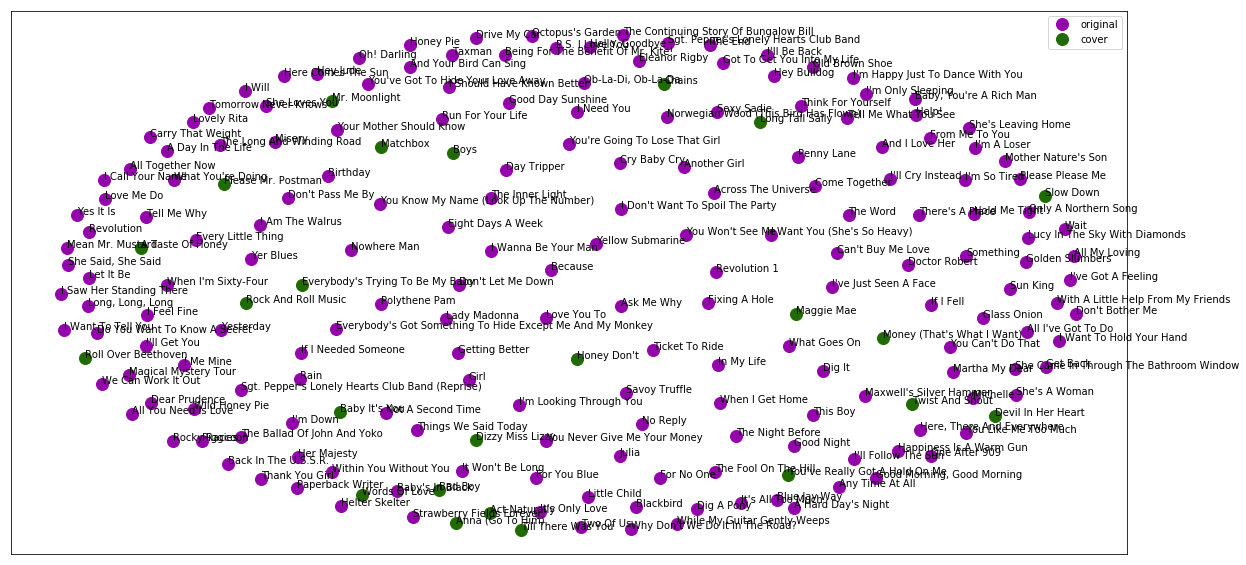

In [15]:
matrix = get_matrix(df['lemmatized_lyrics_without_stopwords'], 0, 1)
xs, ys = get_positions(matrix)
labels_field = 'cover'
labels = {True: 'cover', False: 'original'}
show_plot(df, labels_field, labels, xs, ys)

Alas... As you see, it would be quite difficult to separate songs into clusters according to their tf-idf representation, and it seems to be no patterns in combining it with originality status. Still, we can change tf-idf parameters and see what happens! We can exclude words that have too low or too high frequency; say, they present in less than 20% of songs and more than in 80% of songs.

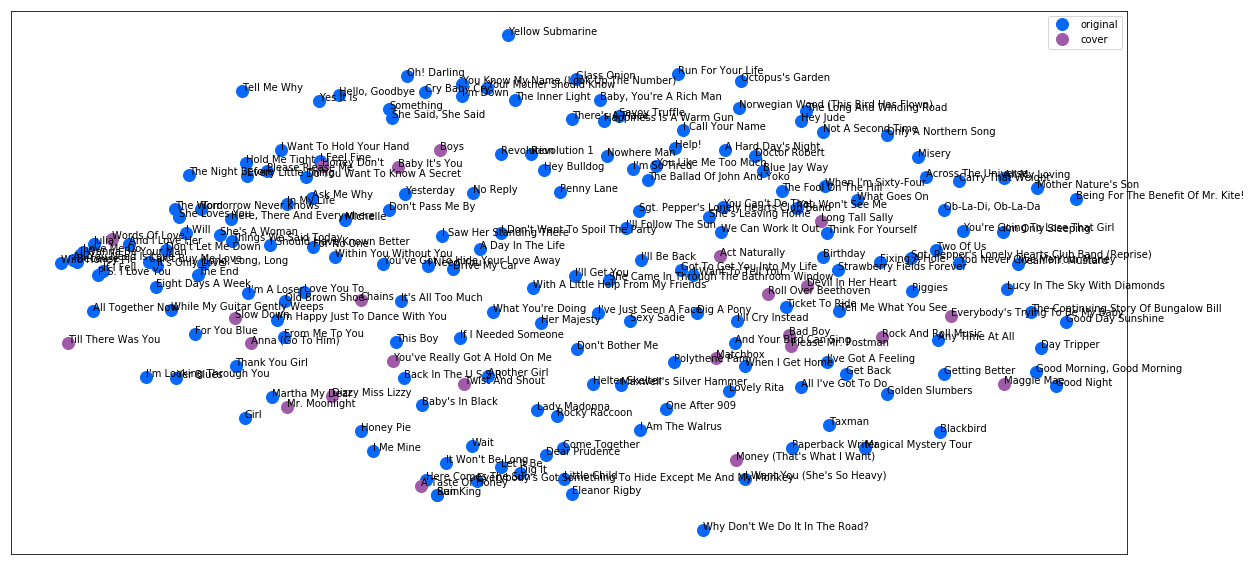

In [16]:
matrix = get_matrix(df['lemmatized_lyrics_without_stopwords'], 0.2, 0.8)
xs, ys = get_positions(matrix)
labels_field = 'cover'
labels = {True: 'cover', False: 'original'}
show_plot(df, labels_field, labels, xs, ys)

It's a bit better, but... Are there real patterns? We see some local concentrations of poins, but that's all.

Let's pay attention to songs' years, now.

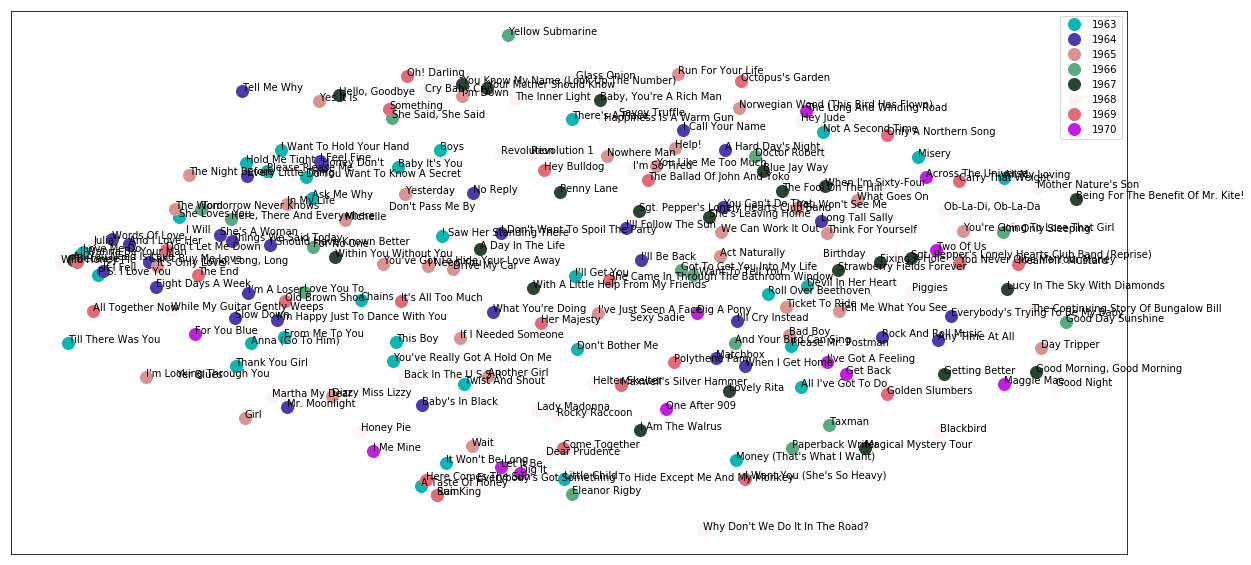

In [17]:
labels_field = 'year'
labels = {year: year for year in list(range(1963, 1973))}
show_plot(df, labels_field, labels, xs, ys)

Chaos reigns! But what if we binarize all these years into just two periods, with 1966 as a border (which actaully makes sense)?..

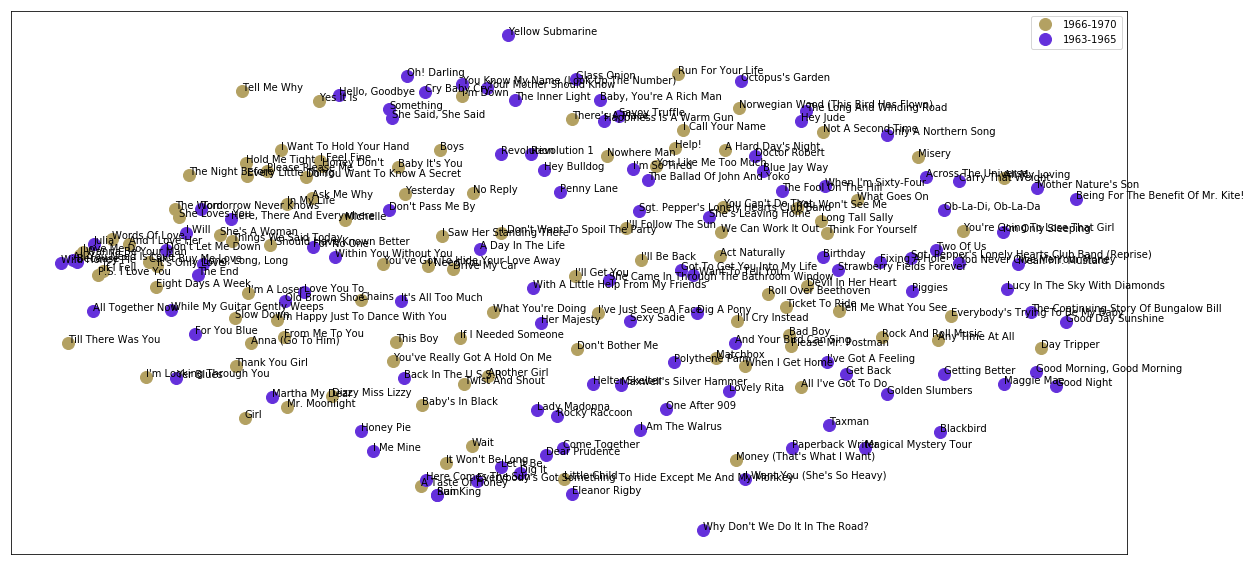

In [22]:
df['first_period'] = df['year'].apply(lambda x: x>1965)
labels_field = 'first_period'
labels = {True: '1963-1965', False: '1966-1970'}
show_plot(df, labels_field, labels, xs, ys)

Hmm... not much better. The last try: author as a parameter!

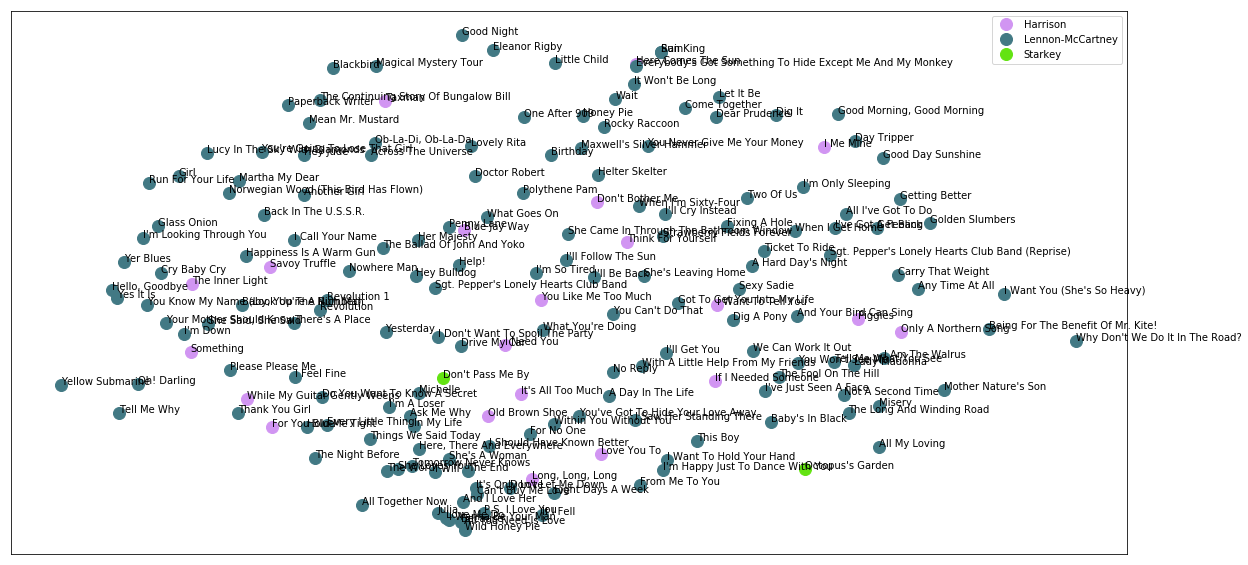

In [19]:
df_orig = df[df['cover']==False]
matrix = get_matrix(df_orig['lemmatized_lyrics_without_stopwords'], 0.2, 0.8)
xs, ys = get_positions(matrix)
labels_field = 'formal_writers'
labels = {'Harrison': 'Harrison', 'Lennon-McCartney': 'Lennon-McCartney', 'Starkey': 'Starkey'}
show_plot(df_orig, labels_field, labels, xs, ys)

It seems that Harrison's songs are concentrated mostly in the lower hemishpere, right? But that's all we can say.

Maybe a clustering algorithm can help us? For example, <a href="https://en.wikipedia.org/wiki/K-means_clustering">K-means</a>? But we need to know the number of clusters beforehand. Let's take only two.

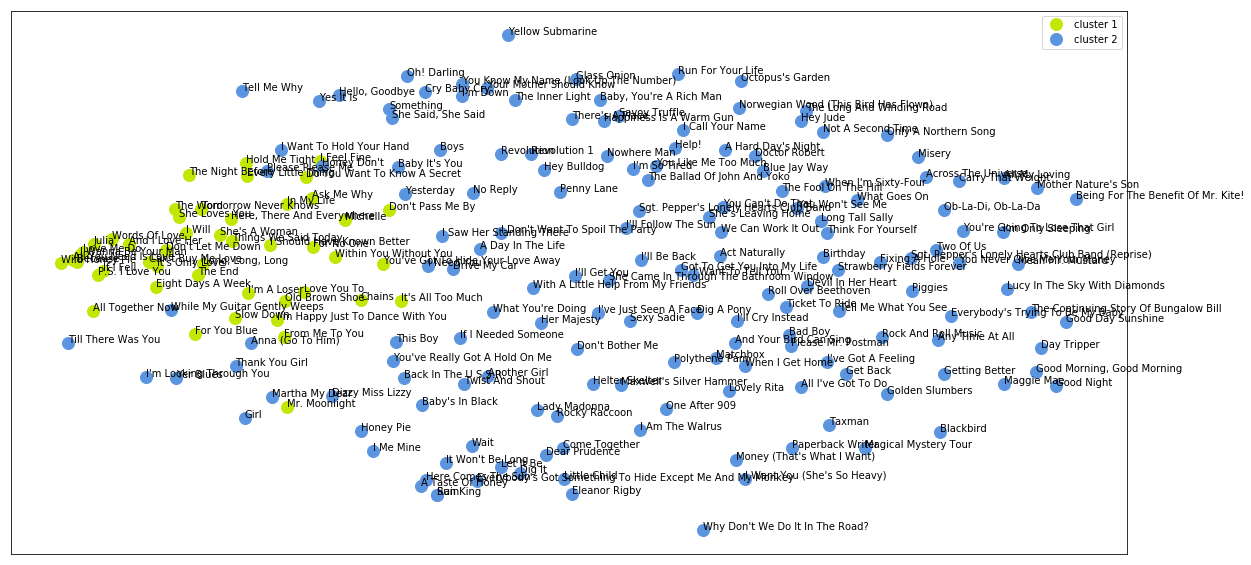

In [21]:
from sklearn.cluster import KMeans

matrix = get_matrix(df['lemmatized_lyrics_without_stopwords'], 0.2, 0.8)
xs, ys = get_positions(matrix)

km = KMeans(n_clusters=2)
km.fit(matrix)
clusters = km.labels_.tolist()

df['cluster'] = clusters
labels_field = 'cluster'
labels = {0: 'cluster 1', 1: 'cluster 2'}
show_plot(df, labels_field, labels, xs, ys)

Not too convincing, right? Sure, a concentration area is captured well, but what does it mean? Songs inside the first cluster are songs about love, but there are many other songs about love, in the other cluster. There are more questions than answers.

<h2>CONCLUSION</h2>

In trying to clusterize the Beatles songs according to tf-idf representations of the lyrics, the 2D plot reveals no possibility to break them into distinct groups, at least visually.